In [1]:
import tensorflow
from tensorflow import keras
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import os
import time

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import csv
import sys

Using TensorFlow backend.


In [2]:
import pydot_ng

In [3]:
name_of_actions = ["clockwise-rotation", "counterclockwise-rotation", "eight", 
                   "flip", "horizontal-rotation", "horizontal-x-shake", "horizontal-y-shake", 
                   "infinity", "vertical-x-shake", "vertical-y-shake", "hold"]
exten = ".csv"
type_of_data = ["acc_", "gyro_"]
folder1 = "split_data_longer/"
folder2 = "split_data_transformed_longer/"

step = 90
start_ind = 0
end_ind = 64

model_dir = "saved_model_dir/"
checkpoint_dir = "model_checkpoint/"
actions_num = 11

In [4]:
def load_answer_file(file): #get answers for files
    dataframe = read_csv(file, header=None, delimiter=',')
    return dataframe.to_numpy()

In [5]:
def load_file(filepath, folder):
    name = filepath[0]
    ind = str(filepath[1])
    dataframe = read_csv(folder + name + '/acc/' + ind + exten, header=None, delimiter=',')
    dataframe_gyro = read_csv(folder + name + '/gyro/' + ind + exten, header=None, delimiter=',')
    dataframe = pd.concat([dataframe, dataframe_gyro], axis=1, sort=False)
    return dataframe.to_numpy() 

In [6]:
def load_group(list_actions):
    datas = list()
    for name in list_actions:
        datas.append(load_file(name, folder1)[:step + 1])
        datas.append(load_file(name, folder2)[:step + 1])
    return dstack(datas) #3d num array, размерности [samples, time steps, features] -> [ts, feat, sampl]

In [7]:
#checker
#list_file_names = [[name_of_actions[0], 1]]
#print(load_group(list_file_names).shape)

(91, 6, 2)


In [7]:
def load_dataset_group(action): #load dataset of group files
    y = np.empty((0,actions_num), int)
    for place in action:
        name1 = folder1 + place[0] + '/answer' + '.csv'
        yy1 = load_answer_file(name1)
        name2 = folder2 + place[0] + '/answer' + '.csv'
        yy2 = load_answer_file(name2)
        y = np.append(y, yy1, axis=0)
        y = np.append(y, yy2, axis=0)
        
    X = load_group(action)
    
    return X, y

In [8]:
def load_dataset(train, test): #get train and test
    trainX, trainy = load_dataset_group(train)
    testX, testy = load_dataset_group(test)
    return trainX, trainy, testX, testy

In [9]:
def saved_model_to_lite(model_file, model): #tflite converter
    converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
    tflite_model = converter.convert()
    open(model_file+".tflite", "wb+").write(tflite_model)

In [10]:
def plot_history(history, number): #plot accuracy
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model ' + str(number) + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model ' + str(number) + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [15]:
def evaluate_model(trainX, trainy, testX, testy, ind, epochs=15): #compile and run model
    history = History()
    batch = 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax')) #^layers
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #accuracy
   
    if not os.path.isdir('./' + checkpoint_dir + str(ind)):
        try:
            os.mkdir(checkpoint_dir + str(ind))
        except OSError:
            print ("Creation of the directory %s failed" % checkpoint_dir + str(ind))
        else:
            print ("Successfully created the directory %s " % checkpoint_dir + str(ind))
    
    filename = checkpoint_dir + str(ind) + '/' + "cp-{epoch:04d}.ckpt"
    filepath = os.path.dirname(filename)
    
    cp_callback = ModelCheckpoint(filepath=filename,
                                 save_weights_only=True,
                                 verbose=1,
                                 period=20)
    
    
    history = model.fit(trainX, trainy, validation_split=0.33, epochs=epochs, batch_size=batch, verbose=0, callbacks=[cp_callback])
    
    print(history.history.keys())
    
    plot_history(history, ind)
    
    saved_model_path = checkpoint_dir + str(ind) + '/model.h5'
    model.save(saved_model_path)
    
    a,accuracy = model.evaluate(testX, testy, batch_size=batch, verbose=0)
    dot_img_file = 'model_' + str(ind) +'.png'
    keras.utils.plot_model(
        model,
        to_file=dot_img_file,
        show_shapes=True ,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
    )
    return accuracy

In [12]:
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [13]:
def run_experiment(trainX, trainy, testX, testy, repeats=10):
    
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy, r, 100) * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    summarize_results(scores)

In [14]:
list_of_all_actions = list()

for name in name_of_actions:
    for ind in range(start_ind, end_ind + 1):
        list_of_all_actions.append([name, ind])

train, test = train_test_split(list_of_all_actions, test_size=0.33, random_state=42)
trainX, trainy, testX, testy = load_dataset(train, test)

In [16]:
trainXm = np.moveaxis(trainX, -1, 0)
testXm = np.moveaxis(testX, -1, 0)


Epoch 00020: saving model to new_model_checkpoint/0/cp-0020.ckpt

Epoch 00040: saving model to new_model_checkpoint/0/cp-0040.ckpt

Epoch 00060: saving model to new_model_checkpoint/0/cp-0060.ckpt

Epoch 00080: saving model to new_model_checkpoint/0/cp-0080.ckpt

Epoch 00100: saving model to new_model_checkpoint/0/cp-0100.ckpt
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


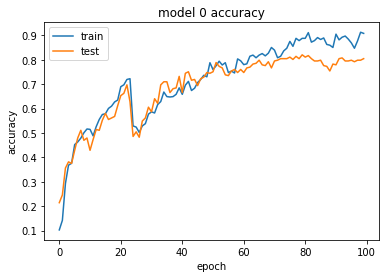

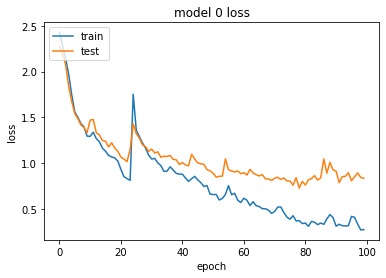

>#1: 81.144

Epoch 00020: saving model to new_model_checkpoint/1/cp-0020.ckpt

Epoch 00040: saving model to new_model_checkpoint/1/cp-0040.ckpt

Epoch 00060: saving model to new_model_checkpoint/1/cp-0060.ckpt

Epoch 00080: saving model to new_model_checkpoint/1/cp-0080.ckpt

Epoch 00100: saving model to new_model_checkpoint/1/cp-0100.ckpt
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


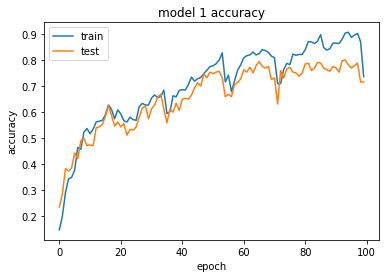

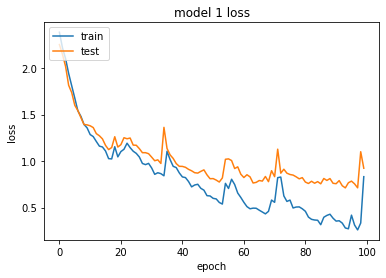

>#2: 73.729

Epoch 00020: saving model to new_model_checkpoint/2/cp-0020.ckpt

Epoch 00040: saving model to new_model_checkpoint/2/cp-0040.ckpt

Epoch 00060: saving model to new_model_checkpoint/2/cp-0060.ckpt

Epoch 00080: saving model to new_model_checkpoint/2/cp-0080.ckpt

Epoch 00100: saving model to new_model_checkpoint/2/cp-0100.ckpt
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


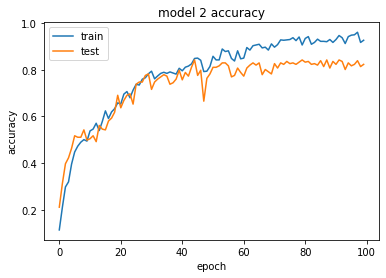

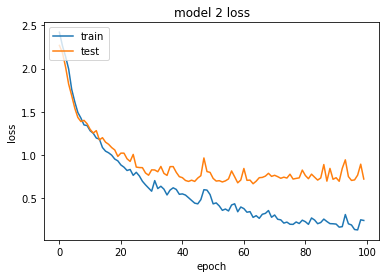

>#3: 83.475
[81.14407062530518, 73.72881174087524, 83.47457647323608]
Accuracy: 79.449% (+/-4.155)


In [30]:
run_experiment(trainXm, trainy, testXm, testy, 3)